In [1]:
import sys
import os
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import plot.viz_sequence as viz_sequence
from feature.util import one_hot_to_seq
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
import scipy.stats
import h5py
import tqdm
tqdm.tqdm_notebook(range(1))

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
base_path = "/users/amtseng/tfmodisco/results/misc_results/bam_reads"

max_hit_reads_in_e2f6_path = os.path.join(base_path, "E2F6_singletask_profile_finetune_fold10_task0_profile_max_hits_reads.tsv")
e2f6_hit_reads_in_max_path = os.path.join(base_path, "MAX_peak_sequences_e2f6_sequence_matches_reads.tsv")

In [4]:
base_path = "/users/amtseng/tfmodisco/results/importance_scores/"

e2f6_imp_scores_path = os.path.join(base_path, "singletask_profile_finetune/E2F6_singletask_profile_finetune_fold10/task_0/E2F6_singletask_profile_finetune_task0_fold10_imp_scores.h5")
max_imp_scores_path = os.path.join(base_path, "singletask_profile_finetune/MAX_singletask_profile_finetune_fold1/task_0/MAX_singletask_profile_finetune_task0_fold1_imp_scores.h5")

base_path = "/users/amtseng/tfmodisco/results/peak_predictions/"

e2f6_preds_path = os.path.join(base_path, "singletask_profile_finetune/E2F6_singletask_profile_finetune_fold10/task_0/E2F6_singletask_profile_finetune_task0_fold10_pred_perf.h5")
max_preds_path = os.path.join(base_path, "singletask_profile_finetune/MAX_singletask_profile_finetune_fold1/task_0/MAX_singletask_profile_finetune_task0_fold1_pred_perf.h5")

In [5]:
out_path = "/users/amtseng/tfmodisco/figures/allele_specific_binding/"
os.makedirs(out_path, exist_ok=True)

### Helper functions

In [6]:
revcomp_dict = str.maketrans("ACGT", "TGCA")

def revcomp_seq(seq):
    return seq.translate(revcomp_dict)
    
def purine_rich_seq(seq):
    if seq.count("A") + seq.count("G") < 0.5 * len(seq):
        return revcomp_seq(seq)
    return seq

In [7]:
def import_allele_count_dicts(
    hit_reads_path, allele_extract_func=None, required_alleles=None, min_alleles=1
):
    """
    Imports the set of read alleles at each position specified in the given file.
    Note that an "allele" here is a subsequence of a read at a given position.
    All alleles are switched to the purine-rich orientation.
    Arguments:
        `hit_reads_path`: path to TSV mapping coordinates to set of read alleles,
            output by `extract_motif_reads.py`
        `allele_extract_func`: if given, this is a function which maps an allele
            (i.e. a substring of a read) to another substring (e.g. a shorter
            window) for consideration
        `required_alleles`: a list of strings; if given, only retain positions
            which have at least one of each of these alleles
        `min_alleles`: if given, only retain positions which have at least this
            many alleles; defaults to 1
    Returns an N x 3 array of coordinates and a parallel array containing
    dictionaries, where each dictionary maps an allele to the count of how many
    times it was seen at that position.
    """
    coords, allele_count_dicts = [], []

    with open(hit_reads_path, "r") as f:
        for line in tqdm.notebook.tqdm(f):
            tokens = line.strip().split("\t")
            coord = (tokens[0], int(tokens[1]), int(tokens[2]))
            seqs = tokens[3].split(",")

            # For simplicity, filter out anything with gaps
            seqs = [seq for seq in seqs if "-" not in seq]

            # Limit to the specified window
            if allele_extract_func:
                seqs = [allele_extract_func(seq) for seq in seqs]

            alleles, counts = np.unique(seqs, return_counts=True)
            alleles = [purine_rich_seq(allele) for allele in alleles]
            count_dict = dict(zip(alleles, counts))

            # Require at least `min_alleles` allele
            if len(alleles) < min_alleles:
                continue

            # Require the required motif to be represented
            if required_alleles and not all(allele in alleles for allele in required_alleles):
                continue

            coords.append(coord)
            allele_count_dicts.append(count_dict)
    
    coords_arr = np.empty((len(coords), 3), dtype=object)
    for i, (chrom, start, end) in enumerate(coords):
        coords_arr[i, 0] = chrom
        coords_arr[i, 1] = start
        coords_arr[i, 2] = end
    return coords_arr, allele_count_dicts

In [8]:
def plot_allele_count_stats(allele_count_dicts):
    """
    Given a list of allele count dictionaries, plots a few figures to
    examine the counts distributions, including:
    1. Scatterplot of top count vs the 2nd top count
    2. Bar plot of which alleles are most common
    """
    # Plot the top vs 2nd-most prevalent allele counts
    top_allele_counts = np.zeros((len(allele_count_dicts), 2))
    for i, d in enumerate(allele_count_dicts):
        counts = sorted(d.values())
        top_allele_counts[i, 0] = counts[-1]
        top_allele_counts[i, 1] = counts[-2]

    top_counts = np.log10(top_allele_counts)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(top_counts[:, 0], top_counts[:, 1], alpha=0.1)

    (min_x, max_x), (min_y, max_y) = ax.get_xlim(), ax.get_ylim()
    min_both, max_both = min(min_x, min_y), max(max_x, max_y)
    ax.set_xlim(min_both, max_both)
    ax.set_ylim(min_both, max_both)
    ax.plot(
        [min_both, max_both], [min_both, max_both],
        color="black", linestyle="--", alpha=0.3, zorder=0
    )

    ax.set_xlabel("Most common allele")
    ax.set_ylabel("2nd most common allele")
    plt.show()

    # Count how often the most common allele is each allele
    counts = {}
    for d in allele_count_dicts:
        max_allele = sorted(d.keys(), key=lambda k: -d[k])[0]
        try:
            counts[max_allele] += 1
        except KeyError:
            counts[max_allele] = 1

    fig, ax = plt.subplots(figsize=(20, 8))
    labels = sorted(counts.keys(), key=lambda k:-counts[k])
    heights = [counts[key] for key in labels]
    ax.bar(labels, heights, 1)
    ax.set_xticklabels(labels, rotation=90)
    plt.show()

In [9]:
def plot_imp_score_track(
    chrom, start, end, profiles_hdf5_path, imp_scores_hdf5_path, task_index, prof_center_size=700,
    score_center_size=150, hyp_score_key="profile_hyp_scores", save_path=None
):
    """
    For a given region, plots the true/predicted profiles and importance scores.
    """
    mid = (start + end) // 2
    prof_start = mid - (prof_center_size // 2)
    prof_end = prof_start + prof_center_size
    score_start = mid - (score_center_size // 2)
    score_end = score_start + score_center_size
    
    with h5py.File(profiles_hdf5_path, "r") as f:
        # Need to use the coordinates of the profiles themselves
        prof_len = f["predictions"]["log_pred_profs"].shape[2]
        prof_coords_chrom = f["coords"]["coords_chrom"][:].astype(str)
        prof_coords_start = f["coords"]["coords_start"][:]
        prof_coords_end = f["coords"]["coords_end"][:]
        mid = (prof_coords_start + prof_coords_end) // 2
        prof_coords_start = mid - (prof_len // 2)
        prof_coords_end = prof_coords_start + prof_len
        match_inds = np.where(
            (prof_coords_chrom == chrom) &
            (prof_coords_start <= prof_start) &
            (prof_coords_end >= prof_end)
        )[0]
        if not match_inds.size:
            print("Warning: did not find sufficiently large prediction track for %s:%d-%s" % (chrom, prof_start, prof_end))
            return
        
        match_ind = match_inds[0]
        
        coord_start, coord_end = prof_coords_start[match_ind], prof_coords_end[match_ind]
        cut_start = prof_start - coord_start
        cut_end = cut_start + prof_center_size
        
        if f["predictions"]["log_pred_profs"].shape[1] == 1:
            task_index = 0
        pred_profs = np.exp(f["predictions"]["log_pred_profs"][match_ind][task_index][cut_start:cut_end])
        true_profs = f["predictions"]["true_profs"][match_ind][task_index][cut_start:cut_end]
    with h5py.File(imp_scores_hdf5_path, "r") as f:
        match_inds = np.where(
            (f["coords_chrom"][:].astype(str) == chrom) &
            (f["coords_start"][:] <= score_start) &
            (f["coords_end"][:] >= score_end)
        )[0]
        if not match_inds.size:
            print("Warning: did not find sufficiently large importance score track for %s:%d-%s" % (chrom, score_start, score_end))
            return
        
        match_ind = match_inds[0]
        
        coord_start, coord_end = f["coords_start"][match_ind], f["coords_end"][match_ind]
        hyp_scores = f[hyp_score_key][match_ind]
        one_hot_seq = f["input_seqs"][match_ind]
        
        cut_start = score_start - coord_start
        cut_end = cut_start + score_center_size
        hyp_scores = hyp_scores[cut_start:cut_end]
        one_hot_seq = one_hot_seq[cut_start:cut_end]
    
    prof_fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
    # Draw profiles
    ax[0].plot(true_profs[:, 0], color="darkslateblue")
    ax[0].plot(-true_profs[:, 1], color="darkorange")
    ax[0].set_title("True ChIP-seq profiles")
    ax[1].plot(pred_profs[:, 0], color="darkslateblue")
    ax[1].plot(-pred_profs[:, 1], color="darkorange")
    ax[1].set_title("Predicted ChIP-seq profiles")
    
    # Draw vertical lines that denote the portion with importance scores
    for i in range(2):
        ax[i].axvline(score_start - prof_start, color="gray")
        ax[i].axvline(score_end - prof_start, color="gray")
    if save_path:
        plt.savefig(
            os.path.join(save_path + "_profiles.svg"), format="svg"
        )
    plt.show()

    score_fig = viz_sequence.plot_weights(
        hyp_scores * one_hot_seq, figsize=(20, 4), subticks_frequency=score_center_size, return_fig=True
    )
    score_fig.tight_layout()
    if save_path:
        plt.savefig(
            os.path.join(save_path + "_impscores.svg"), format="svg"
        )
    plt.show()
    print(one_hot_to_seq(one_hot_seq))

In [10]:
def plot_allele_count_bars(count_dict, top_k=2, save_path=None):
    """
    For a single dictionary mapping alleles to counts, plots the top
    `top_k` in a bar plot.
    """
    fig, ax = plt.subplots(figsize=(20, 8))
    labels = sorted(count_dict.keys(), key=lambda k:-count_dict[k])[:top_k]
    heights = [count_dict[key] for key in labels]
    ax.bar(labels, heights, 0.7)
    ax.set_xticklabels(labels, rotation=90)
    
    if save_path:
        plt.savefig(
            os.path.join(save_path), format="svg"
        )
    plt.show()

### MAX binding in E2F6

In [11]:
e2f6_coords, e2f6_allele_count_dicts = import_allele_count_dicts(
    max_hit_reads_in_e2f6_path,
    allele_extract_func=(lambda seq: seq[1:7]),
    required_alleles=["CACGTG"],  # Require canonical MAX motif
    min_alleles=2  # Require multiple alleles
)

0it [00:00, ?it/s]

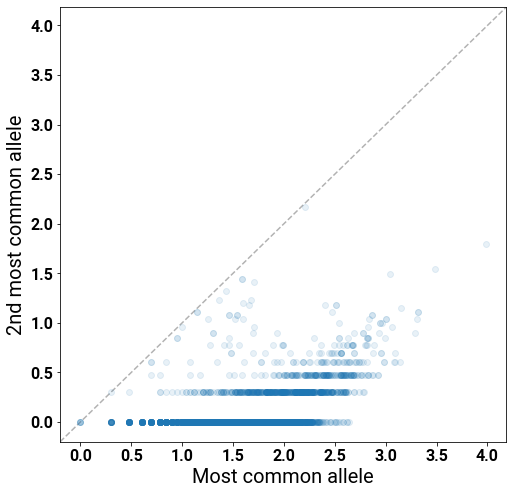

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


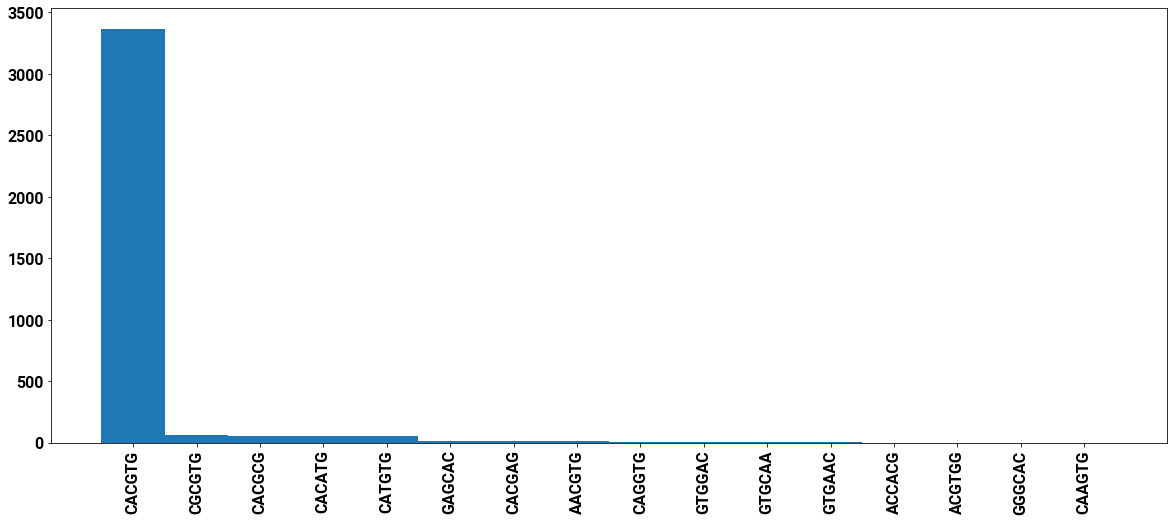

In [12]:
plot_allele_count_stats(e2f6_allele_count_dicts)

2261 chr21 35106427 35106435
{'CACATG': 15, 'CACGTG': 45}
2.1118522811391927e-05


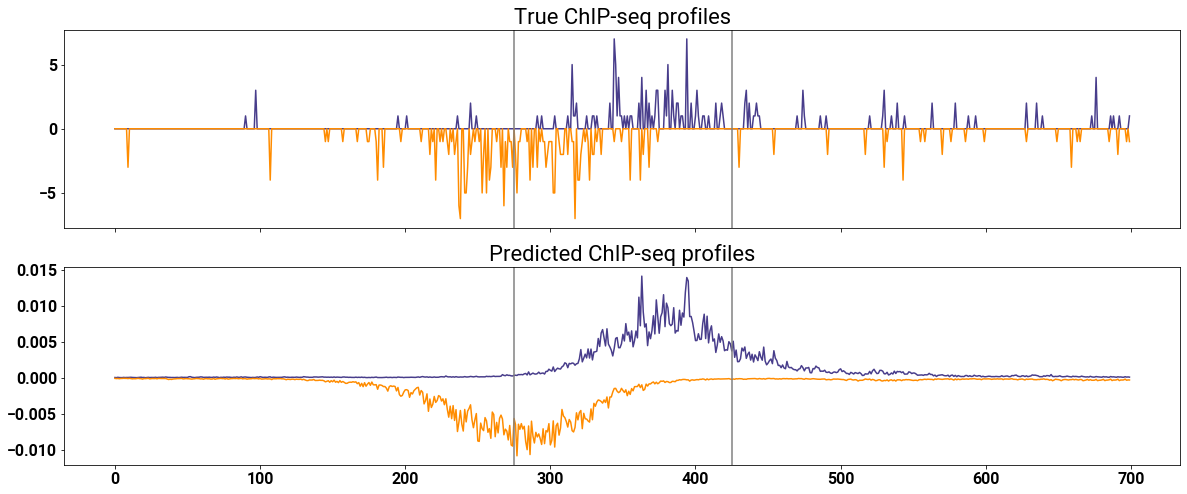

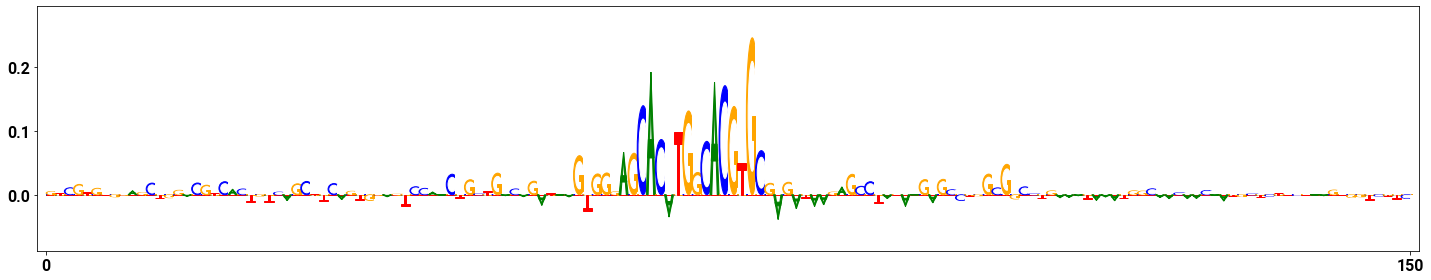

GTCGTGTGGAGCTGGACGTCACTGTCAGCTTCAGTGGAGTCCAACTGCTGACAGATAAGTGGGAGCACATGGCACGTGCGAGATAAGAGCCTATAAGAGCCTGGCGGCCTGAAATAAATGGCAACAACAATGCTCTTCTAAGTGGTCTTC


/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


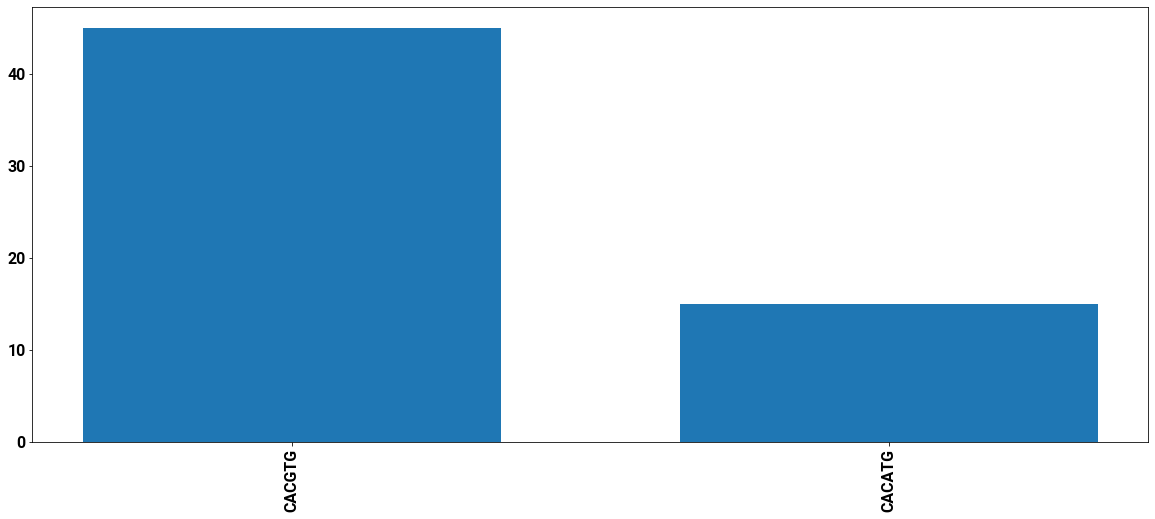


3405 chr8 141508201 141508209
{'ACGTGC': 11, 'CACGTG': 18}
0.06802297383546829



In [13]:
# Find situations where the top counts are appropriate for analysis
inds = []
for i, d in enumerate(e2f6_allele_count_dicts):
    sorted_alleles = sorted(d.keys(), key=lambda k:-d[k])
    sorted_counts = [d[k] for k in sorted_alleles]
    if "CACGTG" != sorted_alleles[0]:
        continue
    
    if len(d) != 2:
        continue
        
    top_1, top_2 = sorted_counts[:2]
    if top_2 < 10:
        continue
    
    inds.append(i)

for i in inds:
    chrom, start, end = e2f6_coords[i]
    count_dict = e2f6_allele_count_dicts[i]
    print(i, chrom, start, end)
    print(count_dict)
    sorted_counts = sorted(count_dict.values(), key=lambda k:-k)
    top_1, top_2 = sorted_counts[:2]
    p_val = 1 - scipy.stats.binom.cdf(top_1, top_1 + top_2, 0.5)
    print(p_val)
    
    if i == 2261:
        plot_imp_score_track(
            chrom, start, end, e2f6_preds_path, e2f6_imp_scores_path, 0,
            save_path=os.path.join(out_path, "E2F6_with_MAX_hit_%d" % i)
        )
        plot_allele_count_bars(
            count_dict,
            save_path=os.path.join(out_path, "E2F6_with_MAX_hit_%d_counts.svg" % i)
        )
        
    print()

### E2F6 binding in MAX

In [14]:
max_coords, max_allele_count_dicts = import_allele_count_dicts(
    e2f6_hit_reads_in_max_path,
    required_alleles=["GCGGG"],  # Require canonical E2F6 motif
    min_alleles=2  # Require multiple alleles
)

0it [00:00, ?it/s]

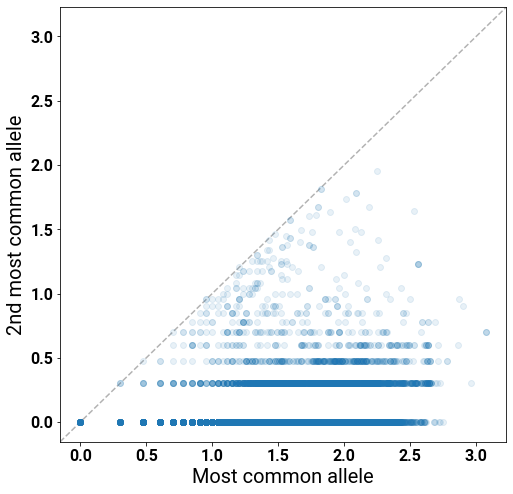

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


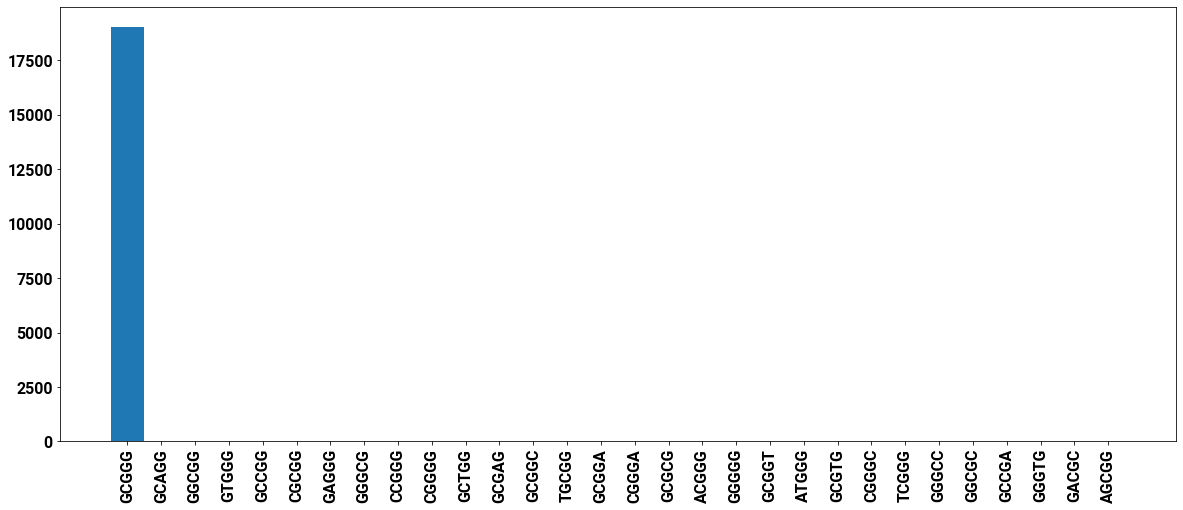

In [15]:
plot_allele_count_stats(max_allele_count_dicts)

1099 chr12 103930366 103930371
{'GCGAG': 39, 'GCGCG': 1, 'GCGGG': 37}
0.3655044411113024


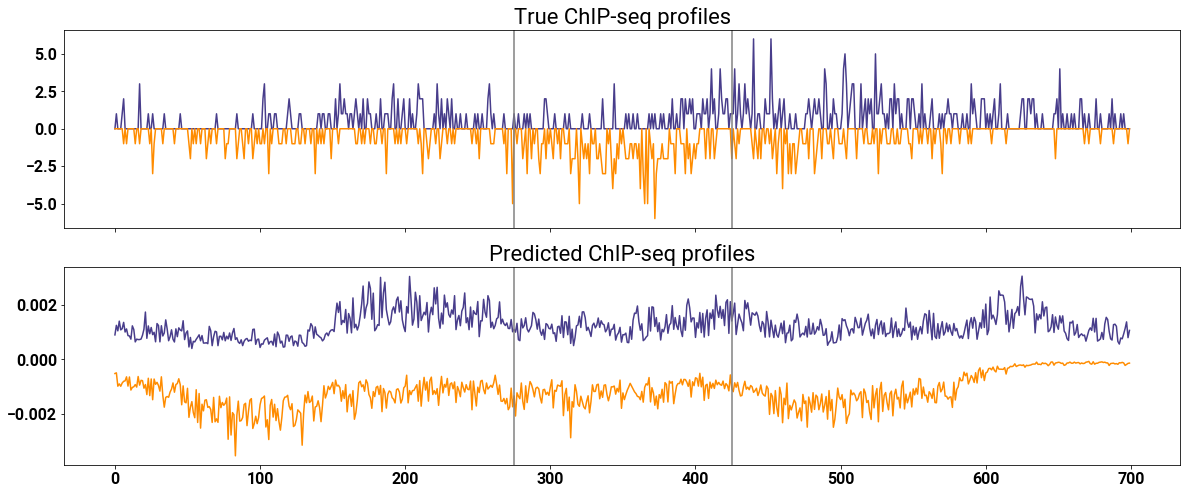

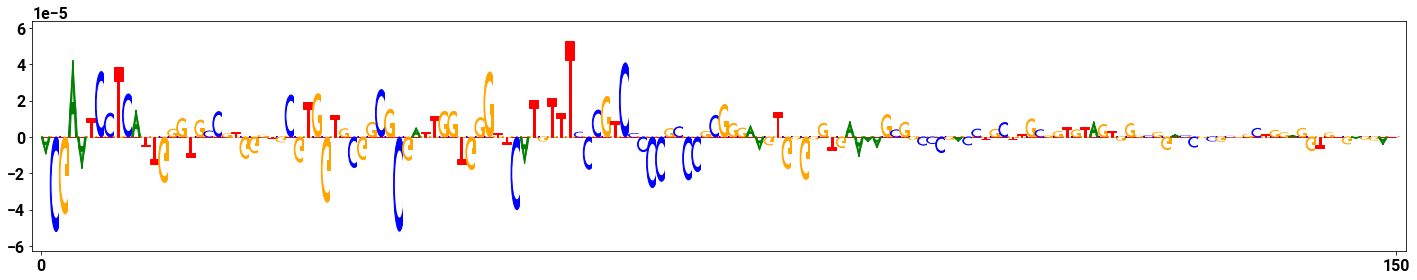

ACGAATCCTCATTGGGTGCCGTGGGTGCGTGGTGCGGCGCGATTGGTGGGTTCATGTTTCCCGTCCCCCGCCCGCGGGAAGTGGGGGTGAAAAGCGGCCCGACCTGCTTGCGGTGTAGTGGGCGGACCGCGCGGCTGGAGGTGTGAGGAT


/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


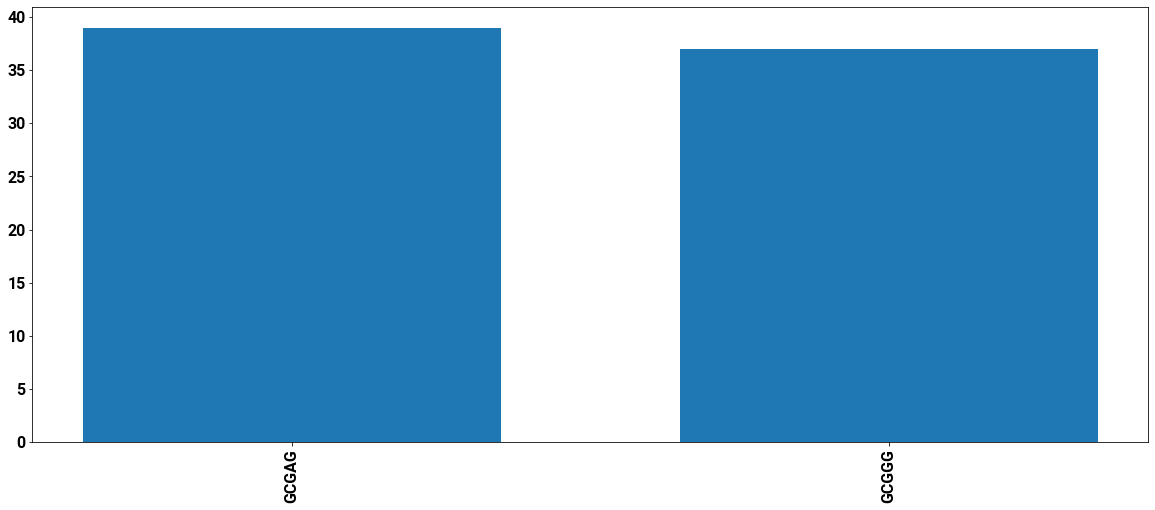


7113 chr6 157823147 157823152
{'CAGGG': 1, 'GGGCC': 1, 'CCGGG': 26, 'GCGGG': 27}
0.3919231511047492

9638 chr4 1247681 1247686
{'GCAGG': 14, 'GCGGG': 15}
0.355535551905632

13858 chr12 103930366 103930371
{'GCGAG': 39, 'GCGCG': 1, 'GCGGG': 37}
0.3655044411113024



In [16]:
# Find situations where the top counts are appropriate for analysis
inds = []
for i, d in enumerate(max_allele_count_dicts):
    sorted_alleles = sorted(d.keys(), key=lambda k:-d[k])
    sorted_counts = [d[k] for k in sorted_alleles]
    
#     if len(d) != 2:
#         continue
        
    if "GCGGG" not in sorted_alleles[:2]:
        continue
        
    if np.sum(sorted_counts) < 20:
        continue
        
    if sorted_counts[0] / sorted_counts[1] > 1.1:
        continue
        
    all_alleles = "".join(sorted_alleles)
    if "A" not in all_alleles and "T" not in all_alleles:
        continue
    
    inds.append(i)

for i in inds:
    chrom, start, end = max_coords[i]
    count_dict = max_allele_count_dicts[i]
    print(i, chrom, start, end)
    print(count_dict)
    sorted_counts = sorted(count_dict.values(), key=lambda k:-k)
    top_1, top_2 = sorted_counts[:2]
    p_val = 1 - scipy.stats.binom.cdf(top_1, top_1 + top_2, 0.5)
    print(p_val)
    
    if i == 1099:
        plot_imp_score_track(
            chrom, start, end, max_preds_path, max_imp_scores_path, 0,
            save_path=os.path.join(out_path, "MAX_with_E2F6_hit_%d" % i)
        )
        plot_allele_count_bars(
            count_dict,
            save_path=os.path.join(out_path, "MAX_with_E2F6_hit_%d_counts.svg" % i)
        )
        
    print()